In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score,roc_auc_score, roc_curve, auc
from matplotlib.pylab import plt
import seaborn as sns
from torch.distributions.normal import Normal
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

In [2]:
def sample_xt(zt):
    xt_mode = (zt + xdim / 2).clamp(0, xdim - 1).floor().long()
    xt_params = F.one_hot(xt_mode, num_classes=xdim) * alpha + (1 - alpha) / xdim
    xt_rv = Categorical(xt_params)
    xt_sample = xt_rv.sample()
    xt_onehot_sample = F.one_hot(xt_sample, num_classes = xdim)
    xt_ll = xt_rv.log_prob(xt_sample)
    return xt_sample, xt_onehot_sample, xt_ll


In [3]:
def ROC(y_test, y_prob):
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

## 1. True Data Synthesis

$\ Z_{it}|Z_{i,t-1}$ ~ $\ N$($0.9 Z_{i,t-1}$,$1$)\
$\exists t, \ Y_i | Z_i = \mathcal{I} \{Z_{i,t} \in [1,3]\} * \mathcal{I} \{Z_{i,t-1} \in [1,3]\} * \mathcal{I} \{Z_{i,t-2} \in [1,3]\} $\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))

**Update**

Here are some changes in data generation:
    
1. the bounds of Z in `is_consecutive()` is modified from $[1, 3]$ to $[1, 2]$.

2. Increase the total time step `T`. 

3. Reduce the dimension of X `Xdim`. 

In [4]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')  

In [5]:
def is_consecutive(z,a=1,b=2):
    return (z >= a) * (z <= b)

In [6]:
# model parameters
alpha = 0.9

# structural constants
xdim = 30
N = 20_000  # number of patients
T = 50  # total time steps

# Yi
success_prob = 0.5
Y = torch.zeros((N,1))

# random variables
# Omega = torch.tensor((1., 50.1))
Z_true = torch.zeros((N, T)) # latent 
X = torch.zeros((N, T)) # observed
X_onehot = torch.zeros((N, T, xdim))

for t in range(0,T):
    # Zit | Zi,t-1, Yi
    meanz = (0.9 * Z_true[:, t - 1]) if t != 0 else torch.zeros((N,))
    Zt = Normal(meanz, 1)
    Z_true[:, t] = Zt.sample()
    
    # Xit | Zit
    X[:,t], X_onehot[:, t], x_ll  = sample_xt(Z_true[:, t])

for t in range(T-2):
    Y[:,0] += is_consecutive(Z_true[:,t]) * is_consecutive(Z_true[:,t+1]) * is_consecutive(Z_true[:,t+2])
    
# truncate the Y values which are greater than 1.
Y = torch.cat((Y, torch.ones((N,1))), 1).min(dim = 1).values

In [7]:
X = X.to(device)
X_onehot = X_onehot.to(device)
Y = Y.view(-1, 1).to(device)
Z_true = Z_true.to(device)

In [8]:
np.unique(X.cpu().data.numpy(), return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.], dtype=float32),
 array([  3291,   3438,   3311,   3145,   3327,   3382,   3506,   4121,
          5809,  11096,  24038,  48201,  86013, 130771, 165010, 165609,
        132522,  86871,  48549,  23734,  11192,   5822,   3940,   3318,
          3412,   3320,   3350,   3302,   3325,   3275]))

## 2. Train-Test Split

In [9]:
idx = torch.randperm(N)
train_idx = idx[:math.floor(0.8*N)]
test_idx = idx[math.floor(0.8*N):]
X_train = X[train_idx,:]
X_test = X[test_idx,:]
# xd1, xd2, xd3 = X_train.shape
# X_train_lr = X_train.view(xd1, xd2*xd3)
# xd1, xd2, xd3 = X_test.shape
# X_test_lr = X_test.view(xd1, xd2*xd3)

In [10]:
y_train = Y[train_idx]
y_test = Y[test_idx]

## 3. Logistic Regression

In [11]:
lr_accuracy = torch.zeros(T)

X_train_lr = X_train.cpu().data.numpy()
y_train_lr = y_train.cpu().data.numpy().squeeze()

X_test_lr = X_test.cpu().data.numpy()
y_test_lr = y_test.cpu().data.numpy().squeeze()

clf = LogisticRegression().fit(X_train_lr, y_train_lr)

/home/jingoy/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
y_prob_lr = clf.predict_proba(X_train_lr)[:,1]
y_pred_lr = 1*(y_prob_lr > 0.5)

lr_accuracy = accuracy_score(y_train_lr,y_pred_lr)

print(f'Training accuracy: {accuracy_score(y_train_lr, y_pred_lr)}.')

confusion_matrix(y_train_lr, y_pred_lr)

Training accuracy: 0.6198125.


array([[6479, 2354],
       [3729, 3438]])

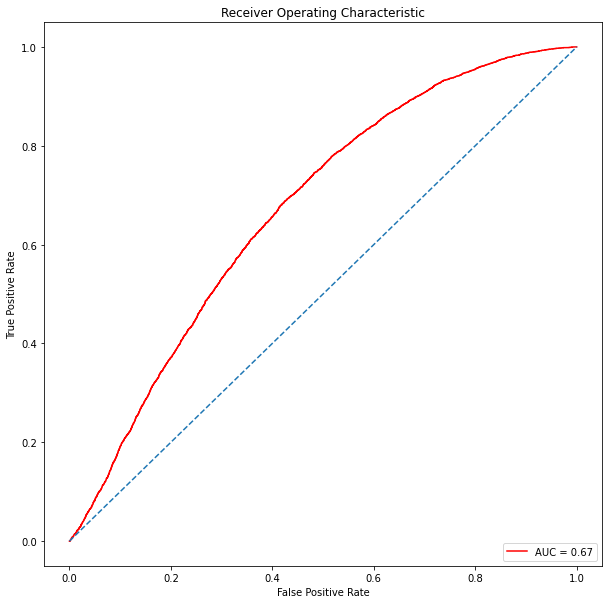

In [13]:
ROC(y_train_lr, y_prob_lr)

In [14]:
y_prob_lr = clf.predict_proba(X_test_lr)[:,1]
y_pred_lr = 1*(y_prob_lr > 0.5)

lr_accuracy = accuracy_score(y_test_lr,y_pred_lr)

print(f'Testing accuracy: {accuracy_score(y_test_lr, y_pred_lr)}.')

confusion_matrix(y_test_lr, y_pred_lr)

Testing accuracy: 0.60875.


array([[1587,  601],
       [ 964,  848]])

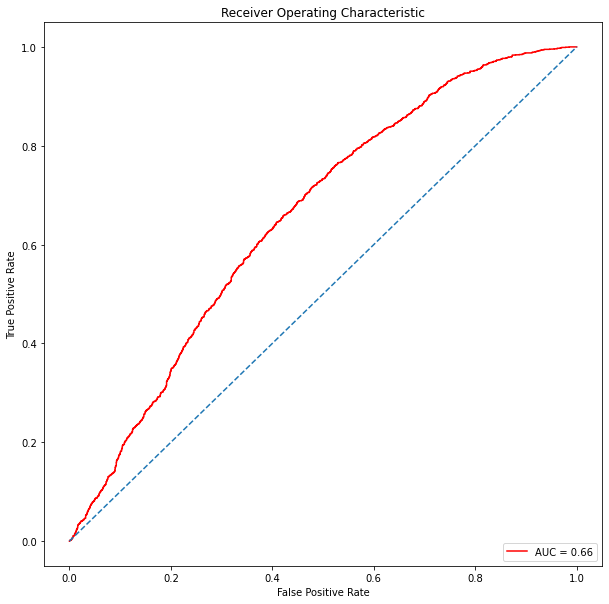

In [15]:
ROC(y_test_lr, y_prob_lr)

## 4. Inference

$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$50.1^{Y_i}$)\

$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$

$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$

In [16]:
X.device

device(type='cuda', index=3)

In [19]:
try:
    K = 100 # number of simulations

    Z = torch.zeros((K, N, T)).to(device)
    Y = torch.zeros((K, N, 1)).to(device)
    logPX_y = torch.zeros((2, K, N, T))


    logPX_y = logPX_y.to(device)

    for t in range(T):
        # Zit | Zi,t-1
        meanz = (0.9 * Z[:, :, t - 1]) if t != 0 else torch.zeros((K, N))
        sd_y = 1
        Zt = Normal(meanz, sd_y)
        Z[:, :, t] = Zt.sample()

    for t in range(T-2):
        # Yi | Zi
        Y[:, :,0] += is_consecutive(Z[:, :,t]) * is_consecutive(Z[:, :,t+1]) * is_consecutive(Z[:, :,t+2])

    for t in range(T):
        # Xit | Zit
        Y_1 = 1 * (Y >= 1).squeeze(2)
        Y_0 = 1 * (Y < 1).squeeze(2)
        xt_mode_1 = (Y_1 * Z[:, :, t] + xdim / 2).clamp(0, xdim - 1).floor().long()
        xt_mode_0 = (Y_0 * Z[:, :, t] + xdim / 2).clamp(0, xdim - 1).floor().long()
        xt_params_1 = F.one_hot(xt_mode_1, num_classes=xdim) * alpha + (1 - alpha) / xdim
        xt_params_0 = F.one_hot(xt_mode_0, num_classes=xdim) * alpha + (1 - alpha) / xdim
        xt_rv_1 = Categorical(xt_params_1)
        xt_rv_0 = Categorical(xt_params_0)
        logPX_y[1, :, :, t] = xt_rv_1.log_prob(X[:, t])
        logPX_y[0, :, :, t] = xt_rv_0.log_prob(X[:, t])

    ElogPX_1k = torch.logsumexp(logPX_y[1], dim = 0) - np.log(K)
    ElogPX_1 = torch.mean(ElogPX_1k,dim = 1)

    ElogPX_0k = torch.logsumexp(logPX_y[0], dim = 0) - np.log(K)
    ElogPX_0 = torch.mean(ElogPX_0k,dim = 1)     


    logPX_Y1 = ElogPX_1 + np.log(success_prob)
    logPX_Y0 = ElogPX_0 + np.log(1-success_prob)
    logPY1_X = logPX_Y1 - (logPX_Y1.exp() + logPX_Y0.exp()).log()
    Y_pred = 1*(logPY1_X.exp() > 0.5)

except:
    torch.cuda.empty_cache()
    

In [20]:
ElogPX_1k = torch.logsumexp(logPX_y[1], dim = 0) - np.log(K)
ElogPX_1 = torch.mean(ElogPX_1k,dim = 1)

ElogPX_0k = torch.logsumexp(logPX_y[0], dim = 0) - np.log(K)
ElogPX_0 = torch.mean(ElogPX_0k,dim = 1)

In [21]:
logPX_Y1 = ElogPX_1 + np.log(success_prob)
logPX_Y0 = ElogPX_0 + np.log(1-success_prob)
logPY1_X = logPX_Y1 - (logPX_Y1.exp() + logPX_Y0.exp()).log()
Y_pred = 1*(logPY1_X.exp() > 0.5)

In [22]:
y_test_np = y_test.cpu().data.numpy()
logPY1_X_np = logPY1_X.cpu().data.numpy()

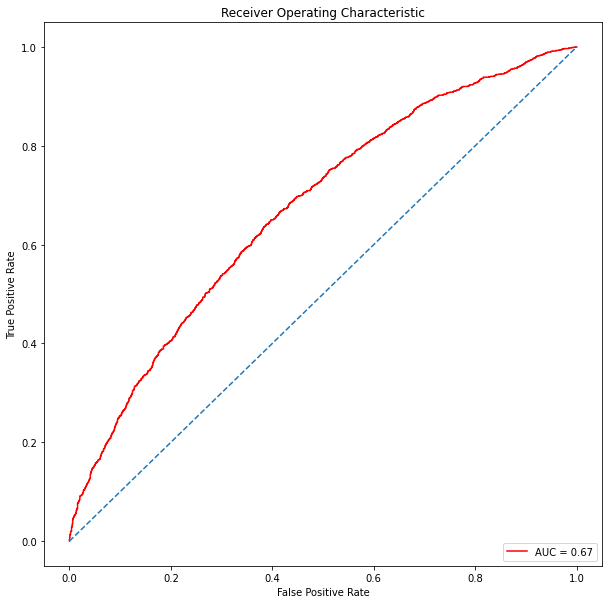

In [23]:
ROC(y_test_np, np.exp(logPY1_X_np[test_idx]))

## 5. CNN

### 5.1 Load Dataset

In [24]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [25]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(*[
            nn.Conv1d(xdim, T, 3, stride=1), 
            nn.MaxPool1d(2),
            nn.Conv1d(T, 5, 2, stride=1),
            nn.MaxPool1d(2)
        ])
        # TODO: fix the input dimension of this linear layer.
        self.fc1 = nn.Linear(120, 1)
#         self.act1 = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(32, 1)
        self.act2 = nn.Sigmoid()
    
    def forward(self, x):
        bsz = x.shape[0]
        x = self.model(x)
        x = x.view(bsz, -1)
        x = self.fc1(x)
#         x = self.act1(x)
#         x = self.fc2(x)
        
        return self.act2(x)



In [29]:
X_train = X_onehot[train_idx,:,:]
X_test = X_onehot[test_idx,:,:]

In [30]:
train = MyDataset(X_train.permute(0, 2, 1), y_train)
train_loader = DataLoader(train, batch_size=64, drop_last=True, shuffle=True)

test = MyDataset(X_test.permute(0, 2, 1), y_test)
test_loader = DataLoader(test, batch_size=1000, drop_last=True)

### 5.2 Define model, loss and optimizer. 

In [31]:
from torch.optim import Adam, SGD
myCNN = MyCNN().to(device)
optimizer = Adam(myCNN.parameters(), lr = 5e-4)
BCELoss = nn.BCELoss()

In [32]:
myCNN

MyCNN(
  (model): Sequential(
    (0): Conv1d(30, 50, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(50, 5, kernel_size=(2,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=120, out_features=1, bias=True)
  (act2): Sigmoid()
)

### 5.3 Train

In [33]:
epoch = 10
loss_value = 0

for e in range(epoch):
    for idx, (batch_X, batch_y) in enumerate(train_loader):

        optimizer.zero_grad()
        y_hat = myCNN(batch_X)
        loss = BCELoss(y_hat, batch_y)
        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        if idx > 0 and not idx % 500:
            print(f'epoch: {e}/{epoch}, steps: {idx}, current_loss: {loss.item()}, loss: {loss_value / 500}.')
            loss_value = 0
    
    loss_value = 0

print('Finish training.')

RuntimeError: size mismatch, m1: [64 x 55], m2: [120 x 1] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [ ]:
pred_prob = []
labels = []

myCNN.eval()
with torch.no_grad():
    for input_id, label in train_loader:
        # True labels
        labels.append(label.squeeze())
        # Predict probability
        y_prob = myCNN(input_id)
        pred_prob.append(y_prob)
        
labels = torch.cat(labels)
pred_prob = torch.cat(pred_prob)
pred_labels = 1 * (pred_prob > 0.5)

labels = labels.cpu().data.numpy()
pred_labels = pred_labels.cpu().data.numpy()
pred_prob = pred_prob.cpu().data.numpy()

In [ ]:
print(f'Training accuracy: {accuracy_score(labels, pred_labels)}.')

confusion_matrix(labels, pred_labels)

In [ ]:
ROC(labels, pred_prob)

In [ ]:
pred_prob = []
labels = []

myCNN.eval()
with torch.no_grad():
    for input_id, label in test_loader:
        # True labels
        labels.append(label.squeeze())
        # Predict probability
        y_prob = myCNN(input_id)
        pred_prob.append(y_prob)
        
labels = torch.cat(labels)
pred_prob = torch.cat(pred_prob)
pred_labels = 1 * (pred_prob > 0.5)

labels = labels.cpu().data.numpy()
pred_labels = pred_labels.cpu().data.numpy()
pred_prob = pred_prob.cpu().data.numpy()


In [ ]:
print(f'Training accuracy: {accuracy_score(labels, pred_labels)}.')

confusion_matrix(labels, pred_labels)

In [ ]:
ROC(labels, pred_prob)

## 6. Sequential Monte Carlo